In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Decision trees
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
#import graphviz
import os

In [4]:
# Set up the data that we want to create a DT on.
# import the fx data , econ and value data for EURUSD.
# then create the features (on trend and econ data) standardise and run a DT on the x_train sample.
# what is  target? 1 day ahead or long days ahead? trade on binary data.
csv_file = {"FXData" : r"C:\Users\edgil\Documents\Masters\dissertation\data\CurrencyData.csv",
            "ValueData" : r"",
            "EconData" : r"",
            }
fxdata = pd.read_csv(csv_file["FXData"])

In [6]:
# use this to make sure the dates are imported correctly as UK dates
fxdata['Date'] = pd.to_datetime(fxdata['Date'], format= '%d/%m/%Y %H:%M')
# Separate out the EURUSD factor
eurusd = fxdata[["Date", "EURUSD"]]


In [7]:
# Build out the featur set on price, this may need to be created using funcional process.
eurusd["logret"] = np.log(eurusd["EURUSD"]) - np.log(eurusd["EURUSD"].shift(1))
# Standardising the daily rets and accumulating the standardised returns, or should we sum the % ret and standardise by its own history
# is difference between different accumulated retusn horizons the same as the macd?
# should we standardise by the 1 year forward vol?
targetlkbk = 5
lkbk1M = 22
lkbk3M = 66
lkbk6M = 132
lkbk9M = 198
eurusd['1MRet'] = eurusd["logret"].rolling(lkbk1M).sum()
eurusd['3MRet'] = eurusd["logret"].rolling(lkbk3M).sum()
eurusd['6MRet'] = eurusd["logret"].rolling(lkbk6M).sum()
eurusd['9MRet'] = eurusd["logret"].rolling(lkbk9M).sum()
eurusd['1Mv3MRet'] = eurusd["1MRet"].sub(eurusd["3MRet"])
eurusd['1Mv6MRet'] = eurusd["1MRet"].sub(eurusd["6MRet"])
# create a target vector to train on.
# must think deeply about what this will look like
# to start, this is a 1M forard return calculation, is it right to use overlapping 1M fwd rets? it seems not...
eurusd["target"] = eurusd['logret'].iloc[::-1].rolling(targetlkbk).sum().values[::-1]
eurusd['target_binary'] = eurusd['target'].apply(np.sign) 

C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\edgil\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [58]:
# Very important step is to truncate the data so that we do not see the last 1 year of data.
# Q. should we not have a rollign window type of model? or just always aggregate the data from the start?
# how ong is testing? we should we the train and test to sizes which make sense to the type of model we use going forward.
eurusd = eurusd.loc[eurusd['Date'] < "2018-01-01 00:00"]
# train size should be at least 5 years?
eurusd_train = eurusd.loc[eurusd['Date'] < "2003-01-01 00:00"]
eurusd_test = eurusd.loc[eurusd['Date'] > "2010-02-01 00:00"]
# create a target vector to train on.
# must think deeply about what this will look like



In [60]:
# Standardise the data using sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# standardise the data now.
# remove dates
data_cols = [col for col in eurusd_train.columns if col not in ["Date", "target", "target_binary"]]
data_train = eurusd_train.loc[:, data_cols]
data_test = eurusd_test.loc[:, data_cols]
eurusd_train_normed = pd.DataFrame(scaler.fit_transform(data_train), columns = list(data_train.columns))
eurusd_test_normed = pd.DataFrame(scaler.transform(data_test), columns = list(data_test.columns)) 
#print(eurusd_train_normed.tail(50))
eurusd_train_normed.shape

(18768, 8)

In [61]:
#### This is where we choose and set up the models!
# need to re do the models here.
X = eurusd_train_normed[['1Mv3MRet', "1Mv6MRet"]]
Y = eurusd_train["target_binary"]
X_test = eurusd_test_normed
Y_test = eurusd_test["target_binary"]
# clean the data and nan values
X = X.replace(np.nan, 0)
Y = Y.replace(np.nan, 0)
X_test = X_test.replace(np.nan, 0)
Y_test = Y_test.replace(np.nan, 0)
#RF = RandomForestClassifier(n_estimators = 150, max_features = 5)
#RF.fit(X, Y)
clf = tree.DecisionTreeClassifier(max_leaf_nodes = 6, max_depth = 8)
clf = clf.fit(X, Y)
#tree.export_graphviz(clf, out_file='tree.dot')

In [62]:
# visualise the data
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
"""export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
                """
tree.export_graphviz(clf, out_file=dot_data, class_names=['Sell',"Hold","Buy"]
                     , filled=True, rounded=True, special_characters = True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("treey.pdf") 
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())

True

In [1]:
# Rough work
#eurusd = eurusd.replace(np.nan, 0)
#print(eurusd.tail(25))
#eurusd["target"] = eurusd['logret'].iloc[::-1].rolling(2).sum().values[::-1]
#print(eurusd.head(10))
#data_cols = [col for col in eurusd_train.columns if col not in ["Date", "target", "target_binary"]]
#print(data_cols)
from graphviz import Digraph

dot = Digraph(comment="The round table")
dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')
dot.render('round-table.gv', view=True)

'round-table.gv.pdf'

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from model_functions import *
from run_decision_tree import *
import datetime
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
file_location = r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\CcyData.csv"
performance_store = {"data_size" : [], "Accuracy_Score" : [], "ntree": [],
                     "Info_Ratio" : [], "run_time" : [], "train_date_st": [], "test_date_st": []}
########################### Set Model Paramaters #############################
# this looks back over a set period as the memory for the LSTM
ntree = 3 # [21, 66]
max_features = 5
test_buffer = 5
data_size = 25000
test_split = 0.75
# signal threshold, when using classifier
thold = 0.55
total_data_needed = int(data_size*(1 + test_split)) + test_buffer
# standardisation window
window = 17500
###### Set Targets ##############
trade_horizon = 24 # in hours
use_risk_adjusted = True # if True: training on the sharpe return else raw
use_binary = False # set to true if you are using the risk adjusted and want it binary for classification score
use_classifier = False
################### Standardise Entire Dataset using rolling lookback windows ###############
data_normed, model_features = initialise_process(file_location, trade_horizon, window, use_risk_adjusted)
#data_normed = data_normed.replace(np.nan, 0)
start_row = 0
use_separated_chunk = False # Use a rolling window to train and test
################ Loop through the full dataset in terms of the training and testing.
while start_row < data_normed.shape[0]:
    # first check if there is enough data left
    if (start_row + total_data_needed) > data_normed.shape[0]:
        # if we are about to go over the limit, then just return the last data_size + test size proportion of data
        trunc_data = data_normed.iloc[-total_data_needed:,:]
    # we need to increment over the data size
    if use_separated_chunk:
        # this means we jump across the full previous train and test data
        trunc_data = data_normed.loc[start_row:,:]
        start_row += total_data_needed
    else:
        # this rools the data so that the new training will overlap on the old test set and create a new separated test set
        trunc_data = data_normed.loc[start_row:,:]
        start_row += data_size
    # standardise the data
    #################### Set up training and testing ########################
    print("start_row %s" % start_row)
    trunc_data.to_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code\dataset\TruncData_%s.csv" % str(start_row)) 
    # create data_set
    train , test = create_train_test_file(trunc_data, data_size, test_split, test_buffer)
    train_sample = train[model_features]
    test_sample = test[model_features]
    # train the model
    # verbose = 1 gives the output of the training.
    print("Starting ML model now end date : %s" % train['Date'].iloc[-1] )
    start_time = datetime.datetime.now()
    results, acc_score = decision_tree(train_sample, test_sample,use_classifier, use_risk_adjusted,ntree, max_features)
    run_time = datetime.datetime.now() - start_time
    test_results = backtester(results, test, trade_horizon)[0]
    strat_return = backtester(results, test, trade_horizon)[1]
    information_ratio = backtester(results, test, trade_horizon)[2]
    train_date = train['Date'].iloc[0]
    test_date = test['Date'].iloc[0]
    performance_df = update_performance(data_size, ntree, acc_score , information_ratio, 
                                        run_time, train_date, test_date, performance_store)
    save_results = r"C:\Users\edgil\Documents\Masters\dissertation\code\dataset\test_result_start%s_useriskadj%s_ntree%s_thold%s.csv" % (start_row, 
                    use_risk_adjusted, ntree, thold)
    save_perf_df = r"C:\Users\edgil\Documents\Masters\dissertation\code\dataset\performance_df_ntree%s_st_row%s.csv" % (ntree,start_row) 
    test_results.to_csv(save_results,index = False)
    performance_df.to_csv(save_perf_df,index = False)

C:\Users\edgil\Documents\Masters\dissertation\code\model_functions.py:65: RuntimeWarning: divide by zero encountered in true_divide
  return data_df['logret'].iloc[::-1].shift(2).rolling(trade_horizon).sum().values[::-1]/data_df['logret'].iloc[::-1].shift(2).rolling(trade_horizon).std().values[::-1]


start_row 25000


Starting ML model now end date : 2006-10-16 19:00:00


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


start_row 50000


Starting ML model now end date : 2007-12-27 07:00:00


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


start_row 75000


Starting ML model now end date : 2011-12-23 23:00:00


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


start_row 100000


Starting ML model now end date : 2015-12-22 15:00:00


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [1]:
##### RUN LOOP on NTREE ####
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from model_functions import *
from run_decision_tree import *
import datetime
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
file_location = r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\CcyData.csv"
performance_store = {"data_size" : [], "Accuracy_Score" : [], "ntree": [],
                     "Info_Ratio" : [], "run_time" : [], "train_date_st": [], "test_date_st": []}
########################### Set Model Paramaters #############################
# this looks back over a set period as the memory for the LSTM
ntrees = [150] # [i for i in range(25,301,25)] # [21, 66]
max_features = 5
test_buffer = 5
max_depth = 30
data_size = 1500 # train every 3 months
# I.e. append the data into one df over each training window, but also use all available up until that point
concat_results = True 
# if the number is > 1, then the code takes that as the number of test points you want to use
test_split = 460 # roughly one month test ahead
# signal threshold, when using classifier
thold = 0.55
total_data_needed = get_total_data_needed(test_split,data_size,test_buffer)
# standardisation window
window = 17500
###### Set Targets ##############
trade_horizon = 24 # in hours
use_risk_adjusted = True # if True: training on the sharpe return else raw
use_binary = False # set to true if you are using the risk adjusted and want it binary for classification score
use_classifier = True
################### Standardise Entire Dataset using rolling lookback windows ###############
data_normed, model_features = initialise_process(file_location, trade_horizon, window, use_risk_adjusted)
#data_normed = data_normed.replace(np.nan, 0)
start_row = 0
use_separated_chunk = False # Use a rolling window to train and test
################ Loop through the full dataset in terms of the training and testing.
while start_row < data_normed.shape[0]:
    # first check if there is enough data left
    if (start_row + total_data_needed) > data_normed.shape[0]:
        # if we are about to go over the limit, then just return the last data_size + test size proportion of data
        trunc_data = data_normed.iloc[-total_data_needed:,:]
    # we need to increment over the data size
    if use_separated_chunk:
        # this means we jump across the full previous train and test data
        trunc_data = data_normed.loc[start_row:,:]
        start_row += total_data_needed
    if concat_results:
        # in this instance, we can to add to the start row first before chunking the data
        start_row += data_size
        # we are training on all data available up until that point, and testing x timeperiods ahead
        trunc_data = data_normed.loc[:start_row,:]  
    else:
        # this rolls the data so that the new training will overlap on the old test set and create a new separated test set
        trunc_data = data_normed.loc[start_row:,:]
        start_row += data_size
    # standardise the data
    #################### Set up training and testing ########################
    print("start_row %s" % start_row)
    #trunc_data.to_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code\dataset\TruncData_%s.csv" % str(start_row)) 
    # create data_set
    train , test = create_train_test_file(trunc_data, data_size, test_split, test_buffer, concat_results)
    train_sample = train[model_features]
    test_sample = test[model_features]
    # train the model
    # verbose = 1 gives the output of the training.
    print("Starting ML model now end date : %s" % train['Date'].iloc[-1] )
    start_time = datetime.datetime.now()
    for ntree in ntrees:
        results, acc_score = decision_tree(train_sample, test_sample,use_classifier,
                                           use_risk_adjusted,ntree, max_features, max_depth)
        run_time = datetime.datetime.now() - start_time
        test_results = backtester(results, test, trade_horizon)[0]
        strat_return = backtester(results, test, trade_horizon)[1]
        information_ratio = backtester(results, test, trade_horizon)[2]
        train_date = train['Date'].iloc[0]
        test_date = test['Date'].iloc[0]
        performance_df = update_performance(data_size, ntree, acc_score , information_ratio, 
                                            run_time, train_date, test_date, performance_store)
    save_test_df = r"C:\Users\edgil\Documents\Masters\dissertation\code\dataset\testresults_df_ntree%s_st_row%s_use_risk%s_use_SepChunk%s_concat%s.csv" % (ntree,start_row,use_risk_adjusted,use_separated_chunk,concat_results) 
    if concat_results:
        # i.e. on the first iteration, keep reulsts as is, then we appedn at subsequent iterations
        if start_row == data_size:
            master_df = test_results
        else:
            master_df = pd.concat([master_df, test_results], axis = 0).reset_index(drop = True)
    else:
        test_results.to_csv(save_test_df, index = False)
    print("finished with row: %s" % str(start_row))
    
save_perf_df = r"C:\Users\edgil\Documents\Masters\dissertation\code\dataset\performance_df_ntree%s_st_row%s.csv" % (ntree,start_row) 
performance_df.to_csv(save_perf_df,index = False)
if concat_results:
    master_df.to_csv(save_test_df, index = False)

C:\Users\edgil\Documents\Masters\dissertation\code\model_functions.py:77: RuntimeWarning: divide by zero encountered in true_divide
  return data_df['logret'].iloc[::-1].shift(2).rolling(trade_horizon).sum().values[::-1]/data_df['logret'].iloc[::-1].shift(2).rolling(trade_horizon).std().values[::-1]


start_row 1500
Starting ML model now end date : 2003-01-14 16:00:00


finished with row: 1500
start_row 3000
Starting ML model now end date : 2003-04-11 04:00:00


finished with row: 3000
start_row 4500
Starting ML model now end date : 2003-07-08 16:00:00


finished with row: 4500
start_row 6000
Starting ML model now end date : 2003-10-03 04:00:00


finished with row: 6000
start_row 7500
Starting ML model now end date : 2003-12-30 16:00:00


finished with row: 7500
start_row 9000
Starting ML model now end date : 2004-03-26 04:00:00


finished with row: 9000
start_row 10500
Starting ML model now end date : 2004-06-22 16:00:00


finished with row: 10500
start_row 12000
Starting ML model now end date : 2004-09-17 04:00:00


finished with row: 12000
start_row 13500
Starting ML model now end date : 2004-12-14 16:00:00


finished with row: 13500
start_row 15000
Starting ML model now end date : 2005-03-11 04:00:00


finished with row: 15000
start_row 16500
Starting ML model now end date : 2005-06-07 16:00:00


finished with row: 16500
start_row 18000
Starting ML model now end date : 2005-09-02 04:00:00


finished with row: 18000
start_row 19500
Starting ML model now end date : 2005-11-29 16:00:00


finished with row: 19500
start_row 21000
Starting ML model now end date : 2006-02-24 04:00:00


finished with row: 21000
start_row 22500
Starting ML model now end date : 2006-05-23 16:00:00


finished with row: 22500
start_row 24000
Starting ML model now end date : 2006-08-18 04:00:00


finished with row: 24000
start_row 25500
Starting ML model now end date : 2006-11-14 16:00:00


finished with row: 25500
start_row 27000
Starting ML model now end date : 2007-02-09 04:00:00


finished with row: 27000
start_row 28500
Starting ML model now end date : 2007-05-08 16:00:00


finished with row: 28500
start_row 30000
Starting ML model now end date : 2007-08-03 04:00:00


finished with row: 30000
start_row 31500
Starting ML model now end date : 2007-10-30 16:00:00


finished with row: 31500
start_row 33000
Starting ML model now end date : 2008-01-25 04:00:00


finished with row: 33000
start_row 34500
Starting ML model now end date : 2008-04-22 16:00:00


KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from model_functions import *
from run_decision_tree import *
import datetime
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
file_location = r"C:\Users\edgil\Documents\Masters\dissertation\code64\data_set\CcyData.csv"
performance_store = {"data_size" : [], "Accuracy_Score" : [], "ntree": [],
                     "Info_Ratio" : [], "run_time" : [], "train_date_st": [], "test_date_st": []}
########################### Set Model Paramaters #############################
# this looks back over a set period as the memory for the LSTM
ntrees = [150] # [i for i in range(25,301,25)] # [21, 66]
max_features = 5
test_buffer = 5
max_depth = 30
data_size = 1500 # train every 3 months
# I.e. append the data into one df over each training window, but also use all available up until that point
concat_results = True 
# if the number is > 1, then the code takes that as the number of test points you want to use
test_split = 460 # roughly one month test ahead
# signal threshold, when using classifier
thold = 0.55
total_data_needed = get_total_data_needed(test_split,data_size,test_buffer)
# standardisation window
window = 17500
###### Set Targets ##############
trade_horizon = 24 # in hours
use_risk_adjusted = True # if True: training on the sharpe return else raw
use_binary = False # set to true if you are using the risk adjusted and want it binary for classification score
use_classifier = True
################### Standardise Entire Dataset using rolling lookback windows ###############
data_normed, model_features = initialise_process(file_location, trade_horizon, window, use_risk_adjusted)
#data_normed = data_normed.replace(np.nan, 0)
start_row = 0
use_separated_chunk = False # Use a rolling window to train and test

C:\Users\edgil\Documents\Masters\dissertation\code\model_functions.py:77: RuntimeWarning: divide by zero encountered in true_divide
  return data_df['logret'].iloc[::-1].shift(2).rolling(trade_horizon).sum().values[::-1]/data_df['logret'].iloc[::-1].shift(2).rolling(trade_horizon).std().values[::-1]


In [9]:
trunc_data= data_normed.loc[:10000,:]
start_row = 10000
# standardise the data
#################### Set up training and testing ########################
print("start_row %s" % start_row)
#trunc_data.to_csv(r"C:\Users\edgil\Documents\Masters\dissertation\code\dataset\TruncData_%s.csv" % str(start_row)) 
# create data_set
train , test = create_train_test_file(trunc_data, data_size, test_split, test_buffer, concat_results)
train_sample = train[model_features]
test_sample = test[model_features]
# train the model
# verbose = 1 gives the output of the training.
print("Starting ML model now end date : %s" % train['Date'].iloc[-1] )
start_time = datetime.datetime.now()
for ntree in ntrees:
    results, acc_score = decision_tree(train_sample, test_sample,use_classifier,
                                       use_risk_adjusted,ntree, max_features, max_depth)
    run_time = datetime.datetime.now() - start_time
    test_results = backtester(results, test, trade_horizon)[0]
    strat_return = backtester(results, test, trade_horizon)[1]
    information_ratio = backtester(results, test, trade_horizon)[2]
    train_date = train['Date'].iloc[0]
    test_date = test['Date'].iloc[0]
    performance_df = update_performance(data_size, ntree, acc_score , information_ratio, 
                                        run_time, train_date, test_date, performance_store)
save_test_df = r"C:\Users\edgil\Documents\Masters\dissertation\code\dataset\rf\testresults_df_ntree%s_st_row%s_use_risk%s_use_SepChunk%s_concat%s.csv" % (ntree,start_row,use_risk_adjusted,use_separated_chunk,concat_results) 
if concat_results:
    # i.e. on the first iteration, keep reulsts as is, then we appedn at subsequent iterations
    if start_row == data_size:
        master_df = test_results
    else:
        master_df = pd.concat([master_df, test_results], axis = 0).reset_index(drop = True)
else:
    test_results.to_csv(save_test_df, index = False)
print("finished with row: %s" % str(start_row))
    
save_perf_df = r"C:\Users\edgil\Documents\Masters\dissertation\code\dataset\rf\performance_df_ntree%s_st_row%s.csv" % (ntree,start_row) 
performance_df.to_csv(save_perf_df,index = False)
if concat_results:
    master_df.to_csv(save_test_df, index = False)

start_row 10000
Starting ML model now end date : 2004-04-27 11:00:00


finished with row: 10000


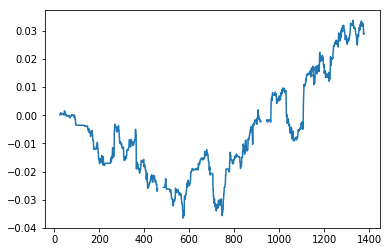

In [11]:
master_df['strat_returns'].cumsum().plot()